# Northwestern County 1st Time Home Buyer Analysis

Author: Armun Shakeri

# Overview

This project analyzes homes available in today's housing market and examines which of those homes would be appropriate for a first time home buyer. Also what factors are most important for a first time home buyer to look at. 

# Business Problem

Recently property values have been increasing throughout the United States. For those wanting to buy their first home,  there are many factors that might raise the price of that home. This project analyzes these factors and explores whether they have a positive or negative affect on price. 

# Data Understanding

The following data is imported from KC housing data and shows different information about homes such as the date a home was sold, price, bedrooms...etc. For this project we will only use some of the data available, others will be removed.

In [1]:
# Import standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
# Run code to explore the data
kc = pd.read_csv('data/kc_house_data.csv')

In [3]:
# this shows information regarding variables in kc dataframe 
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Below we drop values that are irrelevant towards first time hombe buyer analysis 
# We will remove id since we will be making general recommendations 
kc = kc.drop(['id', 'date', 'sqft_living15', 'sqft_lot15'], axis=1)
kc.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045


In [5]:
# Here we drop all Na values. 
kc=kc.dropna()

In [6]:
# First time home buyers will not be looking at homes over $1,000,000. Homes above that threshold will be removed. 
# Homes with bedrooms at or above 4, and greater than 2 floors will also be removed. 
kc = kc[kc.price<=1000000][kc.bedrooms<=10]
kc.head()

<ipython-input-6-4f7939aed66f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kc = kc[kc.price<=1000000][kc.bedrooms<=10]


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045
6,257500.0,3,2.25,1715,6819,2.0,NO,NONE,Average,7 Average,1715,?,1995,0.0,98003,47.3097,-122.327
8,229500.0,3,1.00,1780,7470,1.0,NO,NONE,Average,7 Average,1050,730.0,1960,0.0,98146,47.5123,-122.337


In [7]:
# changed year renovated from float64 to int
kc.yr_renovated=kc.yr_renovated.astype(int)

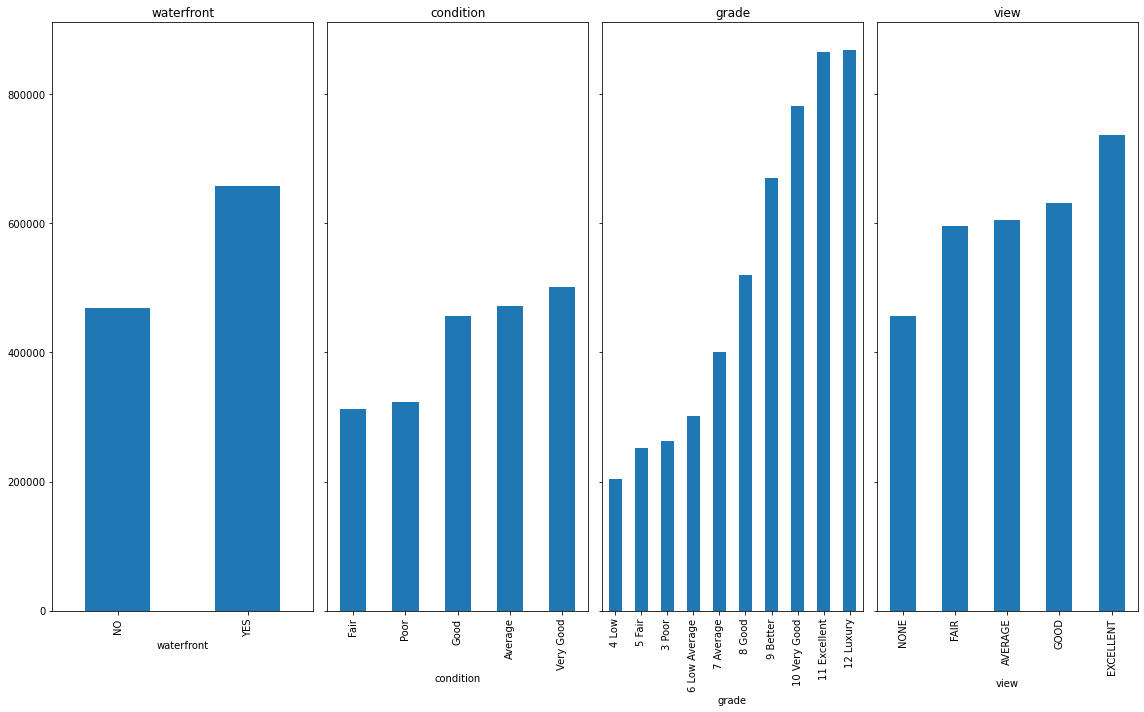

In [8]:
# plotting categorical values vs. price. This shows us all values within categoricals, which values have more
# items and how many categorival values there are. 

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,10), sharey=True)

categoricals = ['waterfront', 'condition', 'grade', 'view']

for col, ax in zip(categoricals, axes.flatten()):
    (kc.groupby(col)
       .mean()['price']            # take the mean of price for each group
       .sort_values()              # sort the groups in ascending order
       .plot
       .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)              # make the title the name of the column
    
fig.tight_layout()

In [9]:
# create dummy variables for categoricals (waterfront, condition and grade)

dummies = pd.get_dummies(kc[categoricals], prefix=categoricals, drop_first=True)     #create dummies and get rid of multicollinearity

kc = kc.drop(categoricals, axis=1)

kc = pd.concat([kc, dummies], axis=1)

kc.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
1,538000.0,3,2.25,2570,7242,2.0,2170,400.0,1951,1991,...,0,0,0,1,0,0,0,0,0,1
3,604000.0,4,3.00,1960,5000,1.0,1050,910.0,1965,0,...,0,0,0,1,0,0,0,0,0,1
4,510000.0,3,2.00,1680,8080,1.0,1680,0.0,1987,0,...,0,0,0,0,1,0,0,0,0,1
6,257500.0,3,2.25,1715,6819,2.0,1715,?,1995,0,...,0,0,0,1,0,0,0,0,0,1
8,229500.0,3,1.00,1780,7470,1.0,1050,730.0,1960,0,...,0,0,0,1,0,0,0,0,0,1


In [10]:
kc.sort_values('yr_renovated', ascending=False).head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
4236,815000.0,6,3.00,2860,17853,1.0,1430,1430.0,1962,2015,...,0,0,0,0,1,0,0,0,0,1
2293,585000.0,5,2.75,2350,4178,1.5,1520,830.0,1922,2015,...,0,0,0,0,1,0,0,0,0,1
16669,420000.0,4,2.75,2400,20000,1.0,1170,1230.0,1961,2015,...,0,0,0,0,1,0,0,0,0,1
18560,476000.0,4,3.00,2890,6885,1.0,1590,1300.0,1945,2015,...,0,0,0,1,0,0,0,0,0,1
3153,830000.0,4,3.00,2020,6000,1.0,1220,800.0,1968,2015,...,0,0,0,0,1,0,0,0,0,1


In [11]:
# Build correlation matrix
corr = kc.corr()
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
price,1.000000,0.297374,0.435886,0.604732,0.092961,0.272821,0.519180,0.058313,0.080385,-0.019334,...,-0.044544,-0.117981,-0.285165,-0.311924,0.165850,0.362899,0.114029,0.074564,0.101597,-0.216589
bedrooms,0.297374,1.000000,0.506150,0.608121,0.021248,0.164551,0.479897,0.168446,-0.000818,-0.150735,...,-0.070787,-0.108213,-0.247644,-0.075148,0.113255,0.166715,0.003465,0.013428,0.020755,-0.037095
bathrooms,0.435886,0.506150,1.000000,0.708833,0.056071,0.503289,0.629544,0.551585,0.018483,-0.207358,...,-0.054398,-0.144310,-0.383311,-0.266581,0.277159,0.292987,0.018464,0.011894,0.055064,-0.070148
sqft_living,0.604732,0.608121,0.708833,1.000000,0.152953,0.339975,0.849580,0.357207,0.012561,-0.208714,...,-0.056201,-0.137445,-0.344185,-0.320253,0.178542,0.391460,0.050722,0.042466,0.092834,-0.148421
sqft_lot,0.092961,0.021248,0.056071,0.152953,1.000000,-0.021943,0.153595,0.040926,0.005354,-0.129003,...,0.001925,0.027643,-0.011671,-0.058623,-0.019002,0.059084,0.013311,-0.010246,0.097362,-0.081716
floors,0.272821,0.164551,0.503289,0.339975,-0.021943,1.000000,0.530493,0.511838,-0.011416,-0.065813,...,-0.025263,-0.075971,-0.227224,-0.291241,0.236064,0.260244,-0.003310,-0.033875,-0.005672,0.030435
sqft_above,0.519180,0.479897,0.629544,0.849580,0.153595,0.530493,1.000000,0.462647,-0.007162,-0.272936,...,-0.047356,-0.113022,-0.298104,-0.360525,0.150208,0.422822,0.013516,-0.002971,0.041356,-0.049609
yr_built,0.058313,0.168446,0.551585,0.357207,0.040926,0.511838,0.462647,1.000000,-0.214284,-0.341456,...,-0.036896,-0.129460,-0.327813,-0.215815,0.234829,0.259988,-0.038578,-0.042602,-0.017382,0.074663
yr_renovated,0.080385,-0.000818,0.018483,0.012561,0.005354,-0.011416,-0.007162,-0.214284,1.000000,0.069837,...,0.004613,-0.006908,0.013943,0.002262,0.010063,-0.012144,0.036568,0.016444,0.039502,-0.048240
zipcode,-0.019334,-0.150735,-0.207358,-0.208714,-0.129003,-0.065813,-0.272936,-0.341456,0.069837,1.000000,...,0.000414,0.003062,0.153232,0.062501,-0.060395,-0.107580,0.057167,0.063477,0.042791,-0.105600


In [12]:
# remove spacing in grade column to help with baseline model 


kc.columns = [grade.replace(' ', '') for grade in kc.columns]

# Data Modeling

In [13]:
# Here shows the different statistical values of the kc dataframe
kc.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,...,grade_4Low,grade_5Fair,grade_6LowAverage,grade_7Average,grade_8Good,grade_9Better,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
count,14701.000000,14701.000000,14701.000000,14701.000000,1.470100e+04,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,...,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000,14701.000000
mean,468512.436161,3.326236,2.043943,1958.936807,1.474440e+04,1.472179,1696.449085,1970.866812,71.803619,98078.144684,...,0.001088,0.011360,0.100605,0.443575,0.292701,0.110809,0.006938,0.012992,0.014897,0.928440
std,196570.694030,0.880761,0.699848,753.381648,4.078150e+04,0.535293,711.128461,29.069026,371.675534,53.216423,...,0.032973,0.105979,0.300816,0.496823,0.455018,0.313906,0.083010,0.113245,0.121145,0.257766
min,82000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,314000.000000,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,1170.000000,1952.000000,0.000000,98033.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,435000.000000,3.000000,2.000000,1850.000000,7.500000e+03,1.000000,1510.000000,1975.000000,0.000000,98065.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,593000.000000,4.000000,2.500000,2420.000000,1.025700e+04,2.000000,2080.000000,1996.000000,0.000000,98118.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1000000.000000,10.000000,7.500000,7120.000000,1.651359e+06,3.500000,5710.000000,2015.000000,2015.000000,98199.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
kc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'waterfront_YES', 'condition_Fair', 'condition_Good',
       'condition_Poor', 'condition_VeryGood', 'grade_11Excellent',
       'grade_12Luxury', 'grade_3Poor', 'grade_4Low', 'grade_5Fair',
       'grade_6LowAverage', 'grade_7Average', 'grade_8Good', 'grade_9Better',
       'view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'view_NONE'],
      dtype='object')

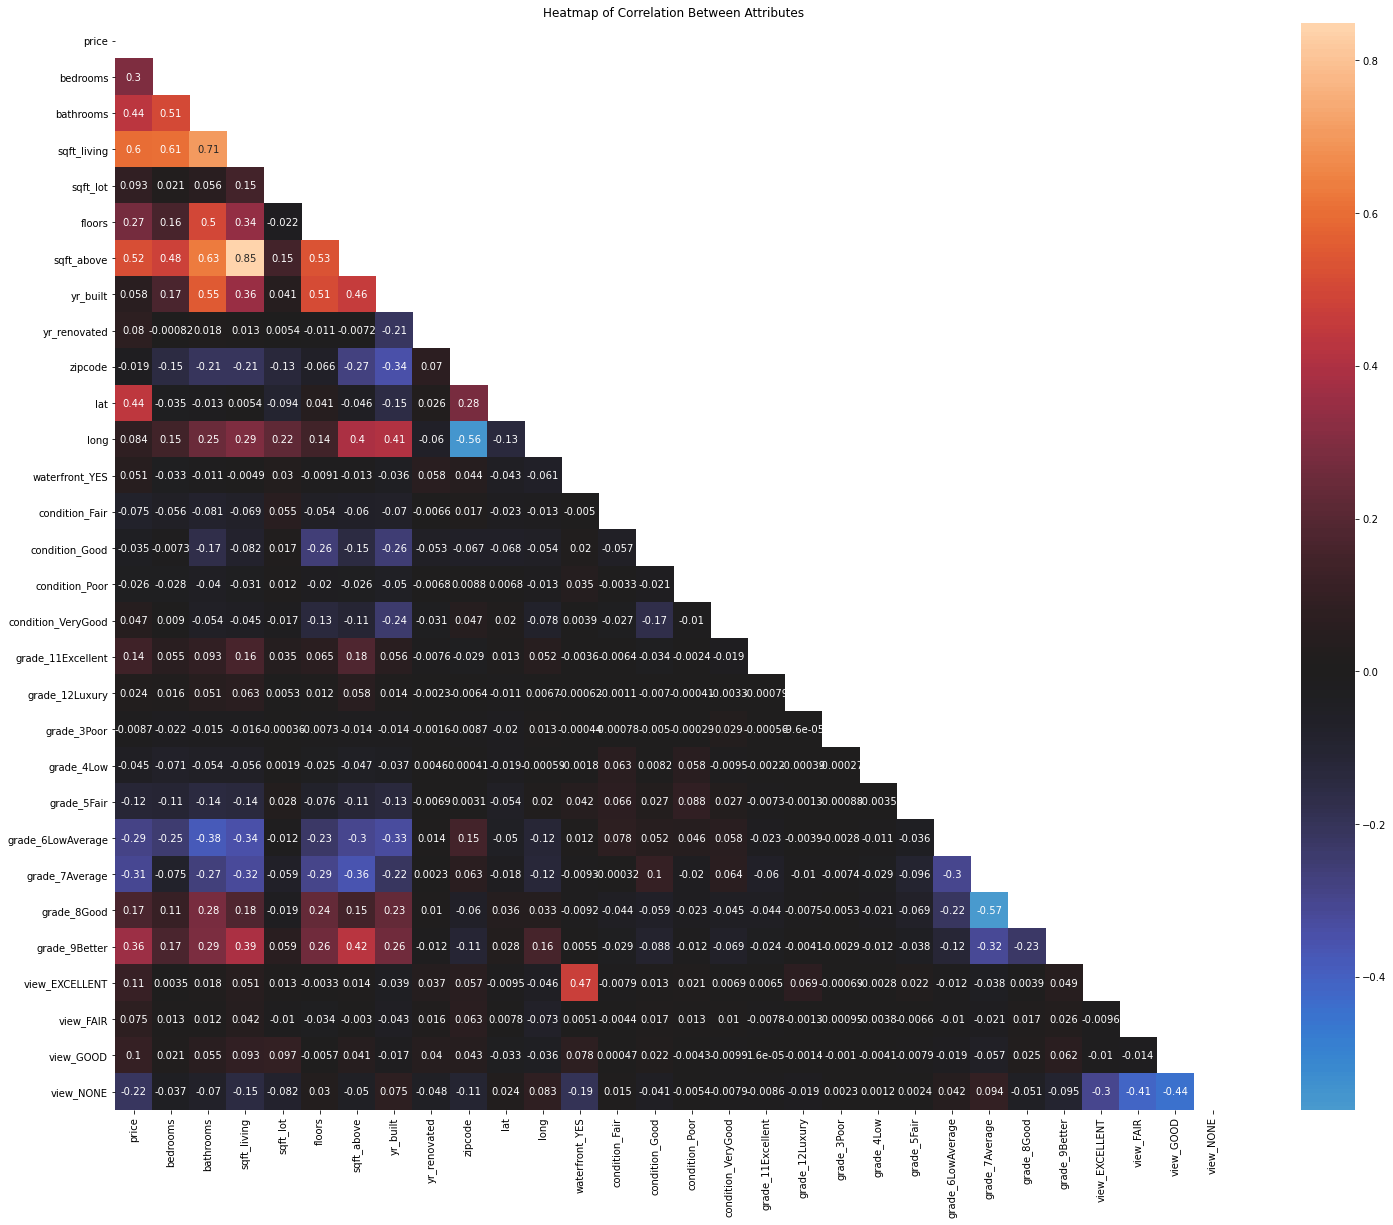

In [15]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(kc.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            center=0);

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes");

# We see below that the highest to lowest correlated are as follows:
# 1) sqft_living x bathrooms
# 2) price x sqft_living
# 3) price x bathrooms

In [16]:
# Build Baseline Model, incorporated majority of variables to help bring R^2 above .65
# based on price, sqft_living is the most correlated followed by sqft_above and price respectively 
b = 'price~bedrooms+bathrooms+sqft_living+sqft_lot+floors+sqft_above+yr_built+yr_renovated+zipcode+lat+long+waterfront_YES+condition_Fair+condition_Good+condition_Poor+grade_11Excellent+grade_12Luxury+grade_3Poor+grade_4Low+grade_5Fair+grade_6LowAverage+grade_7Average+grade_8Good+view_EXCELLENT+view_FAIR+view_GOOD+view_NONE'

model = ols(formula=b, data=kc).fit()

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     1169.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:09:26   Log-Likelihood:            -1.9161e+05
No. Observations:               14701   AIC:                         3.833e+05
Df Residuals:                   14673   BIC:                         3.835e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.404e+06   1.94e+06      1.239      0.215    -1.4e+06    6.21e+06
bedrooms          -9813.5726   1382.412     -7.099      0.000   -1.25e+04   -7103.871
bathrooms          2.665e+04   2270.001     11.739      0.000    2.22e+04    3.11e+04
sqft_living          80.6540      3.130     25.770      0.000      74.519      86.789
sqft_lot              0.1749      0.024      7.416      0.000       0.129       0.221
floors             2.242e+04   2462.461      9.106      0.000    1.76e+04    2.72e+04
sqft_above           10.6161      3.118      3.405      0.001       4.505      16.727
yr_built          -1920.3879     48.944    -39.236      0.000   -2016.324   -1824.451
yr_renovated          5.9012      2.591      2.278      0.023       0.823      10.979
zipcode            -265.7596     22.133    -12.007      0.000    -309.143    -222.376
lat                5.492e+05   7029.473     78.123      0.000    5.35e+05    5.63e+05
long              -1.447e+04   8621.492     -1.678      0.093   -3.14e+04    2428.793
waterfront_YES      1.22e+05   1.96e+04      6.212      0.000    8.35e+04     1.6e+05
condition_Fair    -3.929e+04   9942.780     -3.952      0.000   -5.88e+04   -1.98e+04
condition_Good     1.295e+04   2229.181      5.811      0.000    8583.727    1.73e+04
condition_Poor    -6.292e+04   2.64e+04     -2.386      0.017   -1.15e+05   -1.12e+04
grade_11Excellent  7.879e+04   1.39e+04      5.675      0.000    5.16e+04    1.06e+05
grade_12Luxury    -1.263e+05   7.89e+04     -1.600      0.110   -2.81e+05    2.84e+04
grade_3Poor       -1.099e+05   1.11e+05     -0.990      0.322   -3.28e+05    1.08e+05
grade_4Low        -2.809e+05   2.83e+04     -9.922      0.000   -3.36e+05   -2.25e+05
grade_5Fair       -2.806e+05   9943.222    -28.219      0.000      -3e+05   -2.61e+05
grade_6LowAverage -2.546e+05   5312.393    -47.932      0.000   -2.65e+05   -2.44e+05
grade_7Average     -1.89e+05   3863.208    -48.935      0.000   -1.97e+05   -1.81e+05
grade_8Good       -1.098e+05   3356.462    -32.702      0.000   -1.16e+05   -1.03e+05
view_EXCELLENT     7.408e+04   1.34e+04      5.535      0.000    4.78e+04       1e+05
view_FAIR          7505.8822   9350.611      0.803      0.422   -1.08e+04    2.58e+04
view_GOOD          4414.0786   8932.652      0.494      0.621   -1.31e+04    2.19e+04
view_NONE         -6.722e+04   4966.308    -13.535      0.000    -7.7e+04   -5.75e+04
==============================================================================
Omnibus:                      657.170   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1046.532
Skew:                           0.394   Prob(JB):                    5.60e-228
Kurtosis:                       4.043   Cond. No.                     2.11e+08
======================

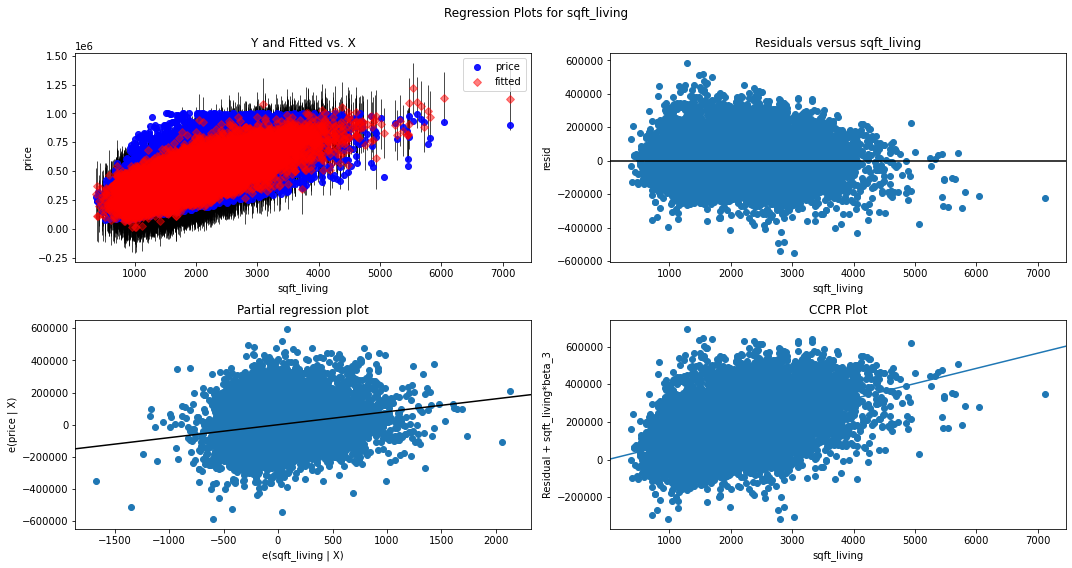

In [22]:
# Visualize terms, specifically sqft_living

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

# the positive correlation in Y and Fitted vs. X graph shows that sqft_living and price are correlated. 
# this is heteroscedastic 

<AxesSubplot:>

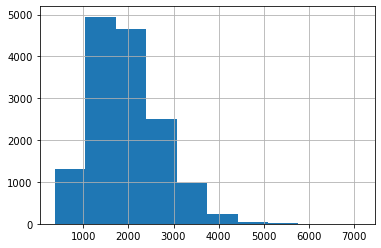

In [23]:
# seems fairly normally distributed, slight skew to the left

kc['sqft_living'].hist()

<AxesSubplot:>

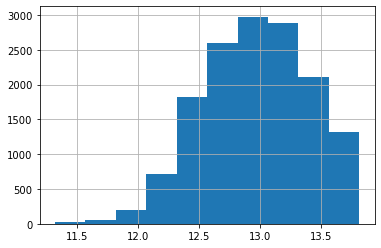

In [29]:
# is this how to log transform?
# what is the x and y axis? 

sqft_scld = np.log(kc['price'])
sqft_scld.hist()

In [30]:
model2 = sm.OLS(sqft_scld, kc['sqft_living']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.883
Model:                            OLS   Adj. R-squared (uncentered):              0.883
Method:                 Least Squares   F-statistic:                          1.114e+05
Date:                Sat, 16 Apr 2022   Prob (F-statistic):                        0.00
Time:                        13:40:36   Log-Likelihood:                         -42740.
No. Observations:               14701   AIC:                                  8.548e+04
Df Residuals:                   14700   BIC:                                  8.549e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living     0.0058   1.74e-05    333.755      0.000       0.006       0.006
==============================================================================
Omnibus:                     1535.767   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2184.808
Skew:                          -0.816   Prob(JB):                         0.00
Kurtosis:                       3.949   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<ipython-input-26-4596469a18d4>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


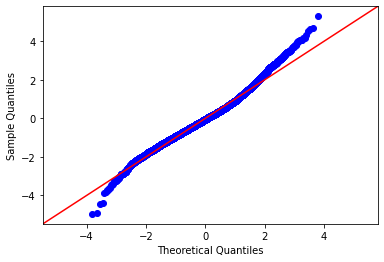

In [26]:
# Q-Q Plot

residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

# This Q-Q plot is very skewed, will need to perform log transform 